In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Objective

This notebook contains the exploratory analysis done to answer the questions posed in the challenge: 

- *How to identify applicants that are not going to perform well based on the features computed from transaction data*

- *To target a particular risk/default rate how do we set that given the mix of applications*

To do this, I will use the data found in the *applications_approved.csv* file as explained in the README file.

# Load data

In [5]:
path = str(Path().resolve()) + '/data/' 
applications_approved = pd.read_csv(path + 'approved_application_data.csv')

applications_approved = applications_approved.rename(columns = {'Unnamed: 0' : 'id'})

# Data exploration

In [6]:
applications_approved.describe()

,id,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,days_since_most_recent_payroll,days_until_next_payroll,bank_balance,overdraft_transactions,nsf_transactions,return_transactions,reverse_transactions,length_of_transaction_history,mortgage,auto_loan,student_loan,traditional_single_payment,installment_loan,predatory_installment_loan,title_loan,pay_advances,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,status
count,4145.000000,4145.000000,4145.000000,4145.000000,4145.00000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000,4145.000000
mean,2072.000000,2795.329450,6.252843,68.887422,437.99492,9.712636,140.729628,35.254914,135.115561,4.072261,1.821230,5.517491,4.850663,226.045887,1.342823,1.117250,0.558504,0.244873,168.739445,9.297764,33.267066,3.455163,38.845916,35.820069,23.016399,0.725399,29.899090,213.542198,1.707841,0.461298,0.017937,187.334138,317.778046,0.800241
std,1196.702762,2500.304614,51.266176,184.837526,460.51468,67.448255,369.385895,241.904024,89.434786,4.337867,1.128403,9.096424,5.303314,1285.698639,3.754272,3.375296,2.321840,1.193456,88.628117,111.967220,122.803512,25.329346,135.003918,118.259035,110.063014,13.808910,86.752272,403.562426,1.733944,1.230599,0.391227,70.422474,137.994972,0.399867
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-7.000000,-890.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.500000,50.000000,50.000000,0.000000
25%,1036.000000,1525.800000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,70.000000,2.000000,1.000000,1.000000,0.000000,0.570000,0.000000,0.000000,0.000000,0.000000,107.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,200.000000,1.000000
50%,2072.000000,2367.330000,0.000000,0.000000,391.38500,0.000000,0.000000,0.000000,144.000000,3.000000,2.000000,4.000000,4.000000,25.490000,0.000000,0.000000,0.000000,0.000000,178.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.500000,1.000000,0.000000,0.000000,200.000000,255.000000,1.000000
75%,3108.000000,3519.960000,0.000000,50.000000,661.14250,0.000000,0.000000,0.000000,176.000000,4.833333,2.000000,8.000000,8.000000,223.780000,1.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,277.500000,2.000000,0.000000,0.000000,250.000000,500.000000,1.000000
max,4144.000000,88818.140000,1175.795000,2798.875000,6498.49250,1238.475000,10070.425000,10599.782500,452.000000,107.538095,17.000000,304.000000,74.000000,71249.610000,61.000000,65.000000,62.000000,28.000000,476.000000,2146.370000,1208.870000,557.350000,2115.000000,1219.800000,1550.000000,541.360000,900.000000,8804.070000,14.000000,20.333333,10.000000,500.000000,500.000000,1.000000


In [26]:
applications_approved.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         4145 non-null   int64  
 1   monthly_income                     4145 non-null   float64
 2   gig_economy_weekly_income          4145 non-null   float64
 3   atm_check_deposits_weekly_income   4145 non-null   float64
 4   direct_deposit_weekly_income       4145 non-null   float64
 5   government_aid_weekly_income       4145 non-null   float64
 6   frequency_heuristic_weekly_income  4145 non-null   float64
 7   large_deposits_weekly_income       4145 non-null   float64
 8   income_length                      4145 non-null   int64  
 9   payrolls_per_month                 4145 non-null   float64
 10  income_sources                     4145 non-null   int64  
 11  days_since_most_recent_payroll     4145 non-null   int64

In [286]:
round(applications_approved.status.value_counts(normalize=True),2)

1    0.8
0    0.2
Name: status, dtype: float64

We can see the data is somewhat unbalanced, it could be useful to under or over sample the data. I will see if it is necessary when modelling.

## Sanity check

In [8]:
# Check for duplicates
print('Duplicates in approved loans DF',len(applications_approved[applications_approved.duplicated()]))

Duplicates in approved loans DF 0


## Univariate analysis

Some of the features were binned for better visualization.

#### Categorical or low range integer features

In [9]:
feat_list = ['income_sources',
             'no_of_other_active_loans', 'state']

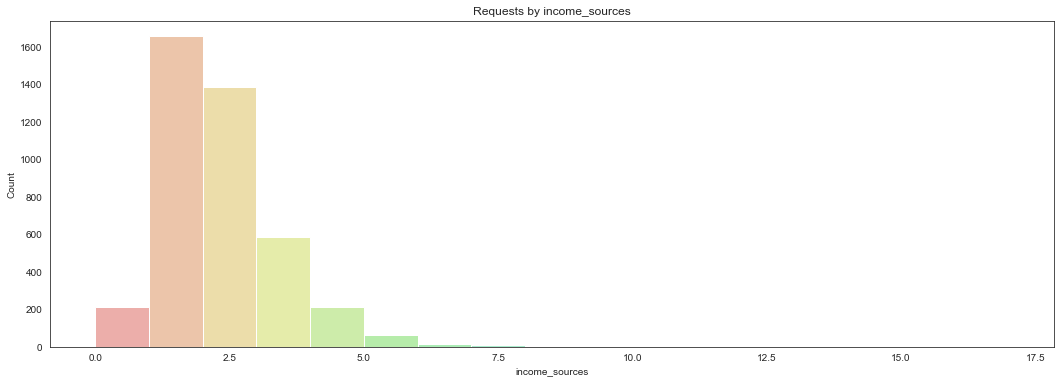

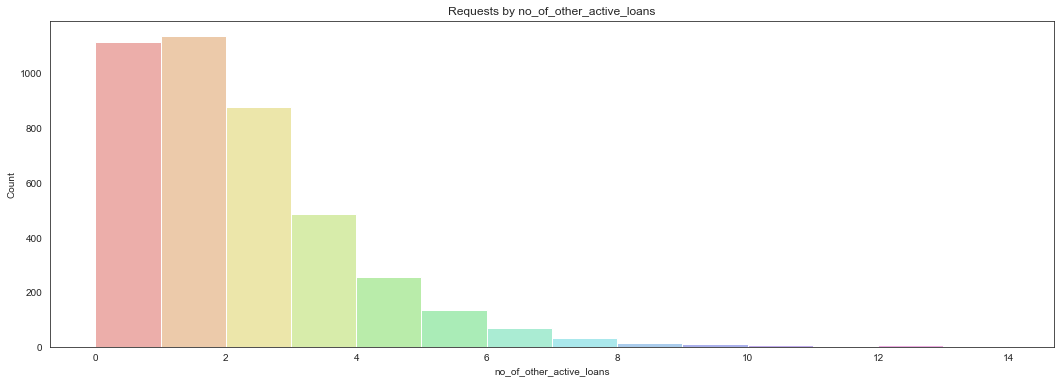

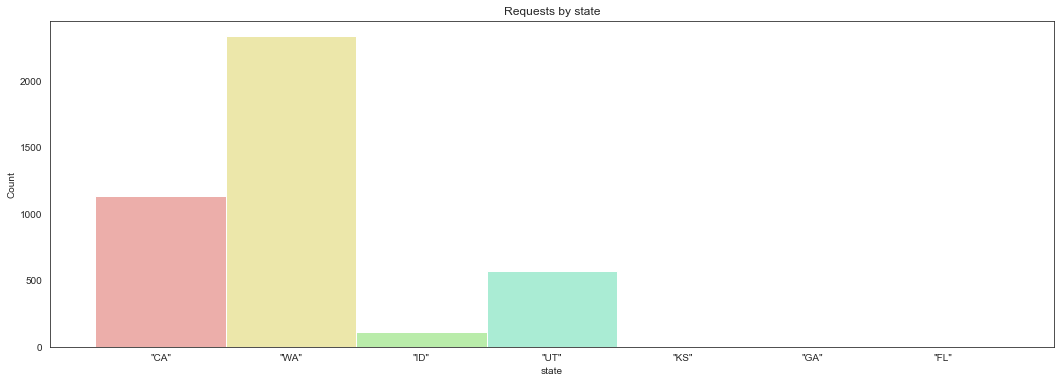

In [10]:
for i in feat_list:
    plt.figure(figsize=(18,6))
    sns.set_style(style='white') 
    sns.histplot(data=applications_approved, x=i, hue = i, 
                 binwidth= 1, palette = 'hls', legend = False).set(title = 'Requests by ' + i) # , 
    plt.show()

#### Numeric features

For numeric features, I will create bins to have a clearer visualization. 

Because of time restraints, I will leave the x axis as the numeric result from qcut - meaning, the labels represent the order in which that label appears, according to the range of values within it- , and the range of values for each of them will be present in the reference box.

In [11]:
# get columns not previously plotted
cols = list(set(applications_approved.columns).difference(feat_list))

In [12]:
# get the rest of the columns into bins for better visualization
lst_bins = []
cols_neg_values = ['days_since_most_recent_payroll', 'days_until_next_payroll', 
                   'bank_balance', 'traditional_single_payment_trend']

for i in cols: 
    if ((i != 'status') & (i != 'id')):
        # for non negative columns, we bin only values greater than zero as to have a better visualization
        if i not in cols_neg_values:
            applications_approved[i + '_bin_labels'] = pd.qcut(applications_approved[applications_approved[i] > 0][i], 
                                                           q = 10, duplicates = 'drop')
            applications_approved[i + '_bin'] = pd.qcut(applications_approved[applications_approved[i] > 0][i], 
                                                     q = 10, labels = False, duplicates = 'drop')
        # for columns that contain negative values, we bin non-zero values to have a better visualization
        else: 
            applications_approved[i + '_bin_labels'] = pd.qcut(applications_approved[applications_approved[i] != 0][i], 
                                                           q = 10, duplicates = 'drop')
            applications_approved[i + '_bin'] = pd.qcut(applications_approved[applications_approved[i] != 0][i], 
                                                     q = 10, labels = False,duplicates = 'drop')
            
        applications_approved[i + '_bin'] = np.where(applications_approved[i] == 0, '0', 
                                                     applications_approved[i + '_bin'])
        applications_approved[i + '_bin_labels'] = np.where(applications_approved[i] == 0, '0',
                                                            applications_approved[i + '_bin_labels'])

        applications_approved[i + '_bin'] = applications_approved[i + '_bin'].apply(lambda x: str(x))
                
        lst_bins.append(i + '_bin')

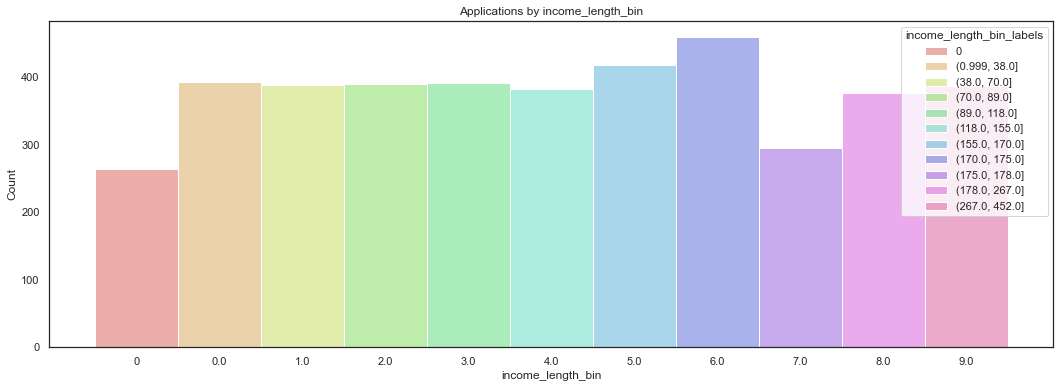

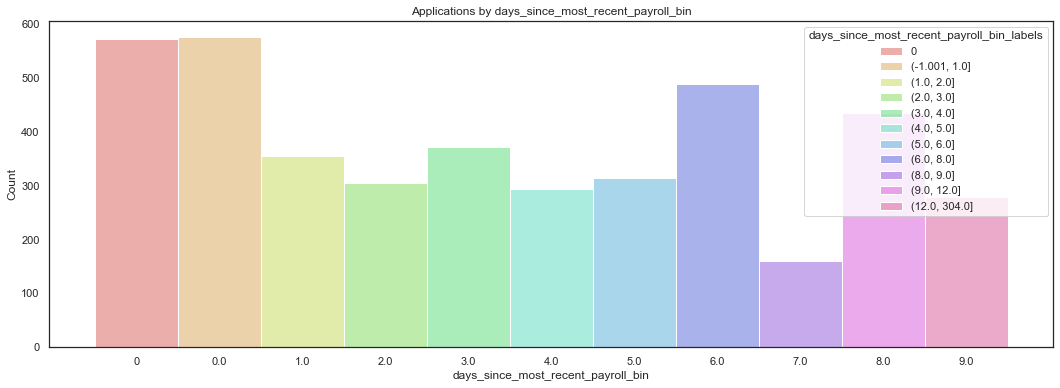

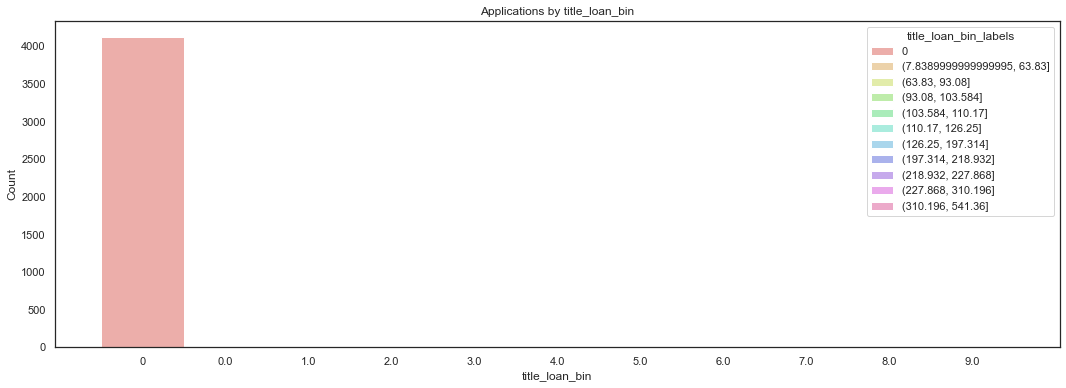

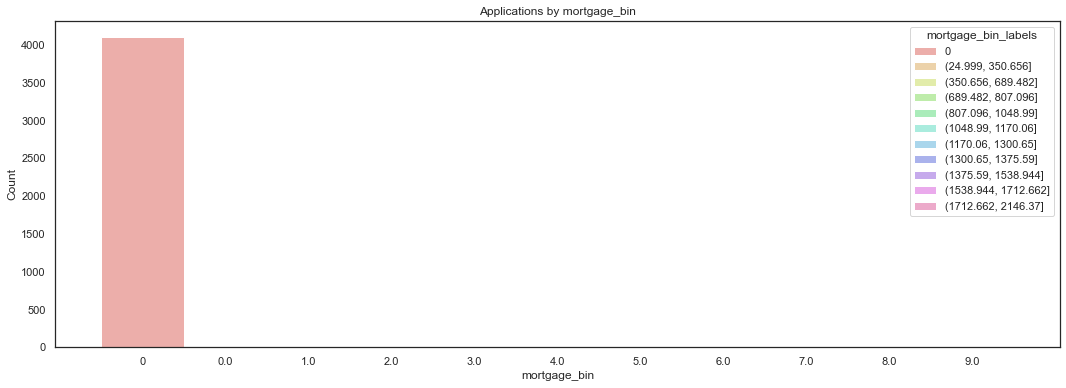

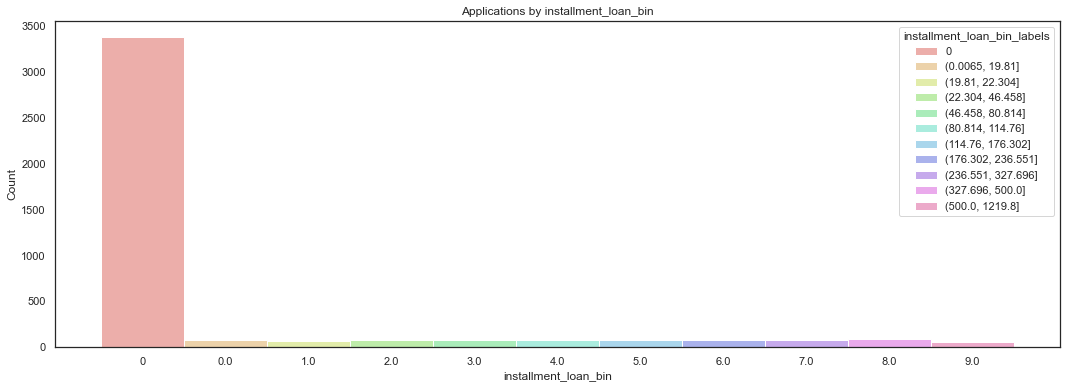

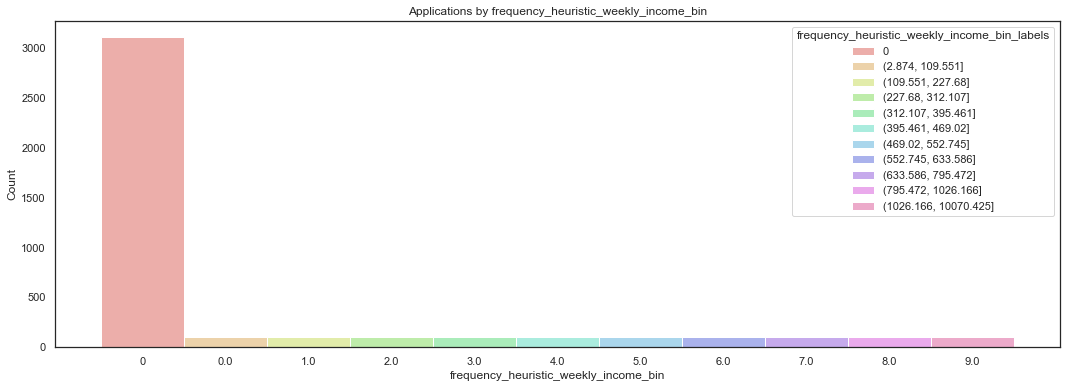

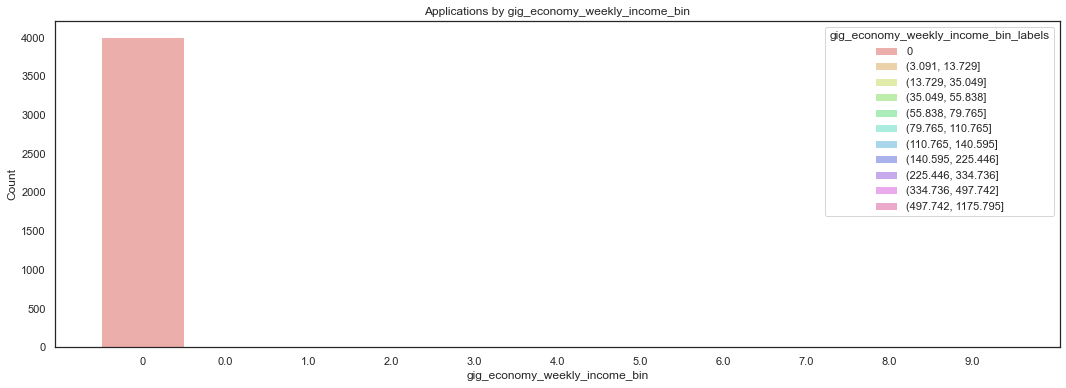

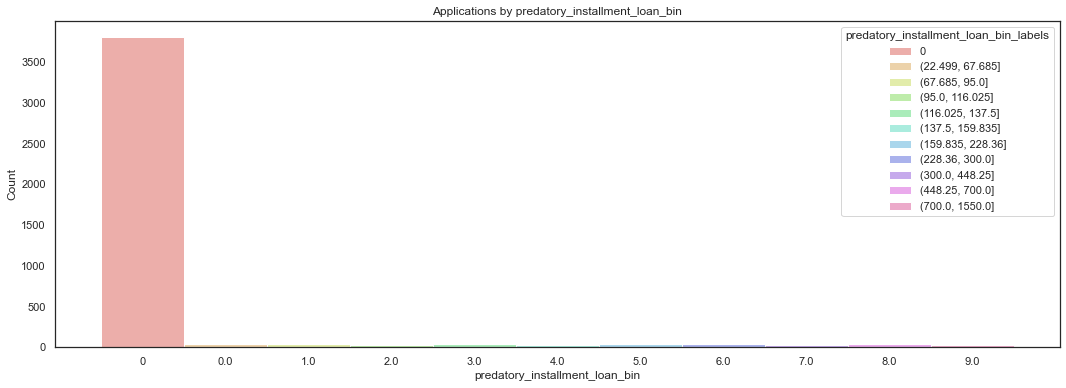

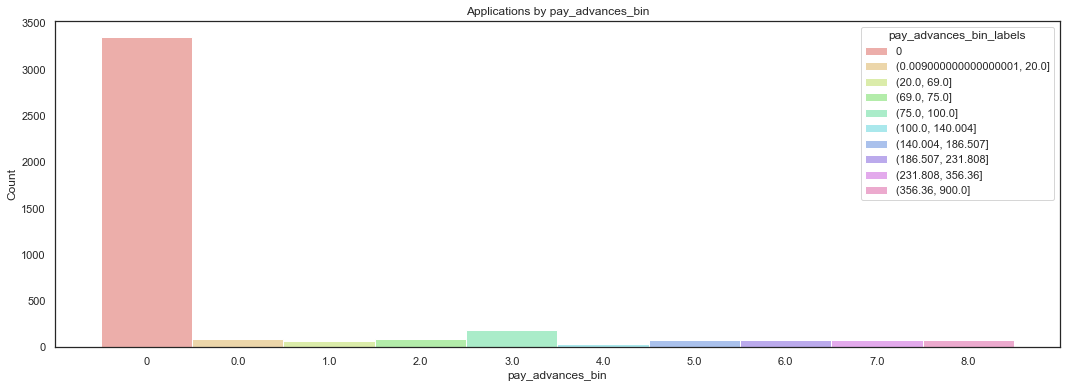

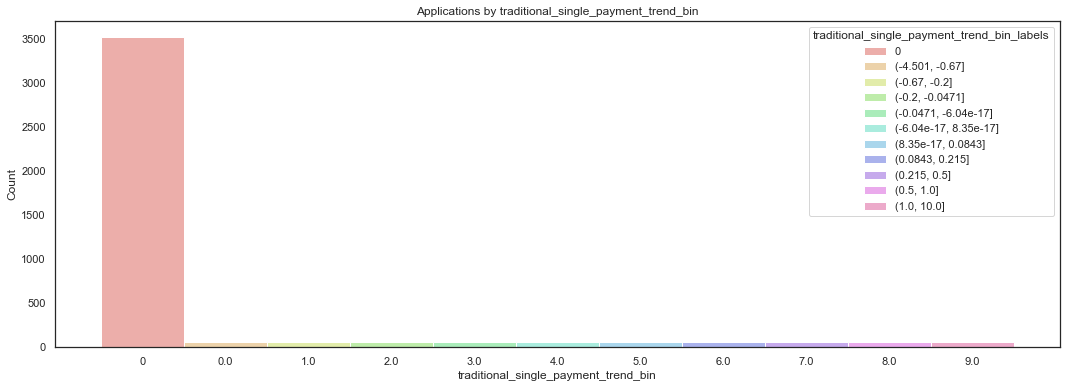

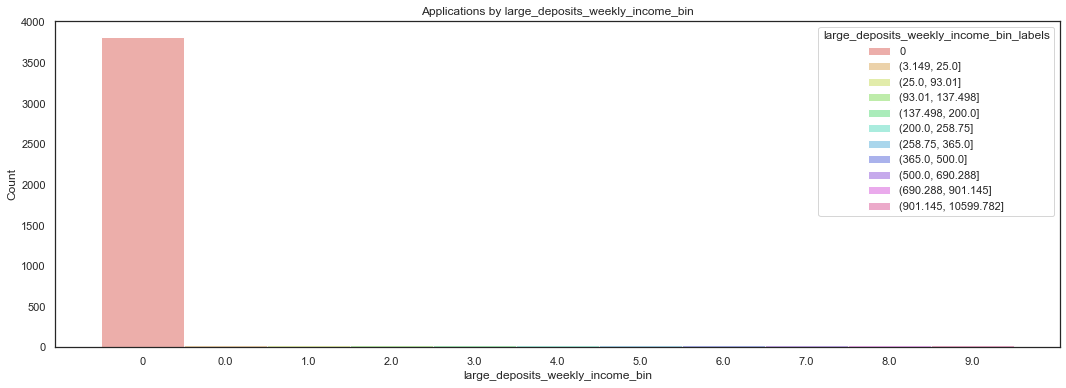

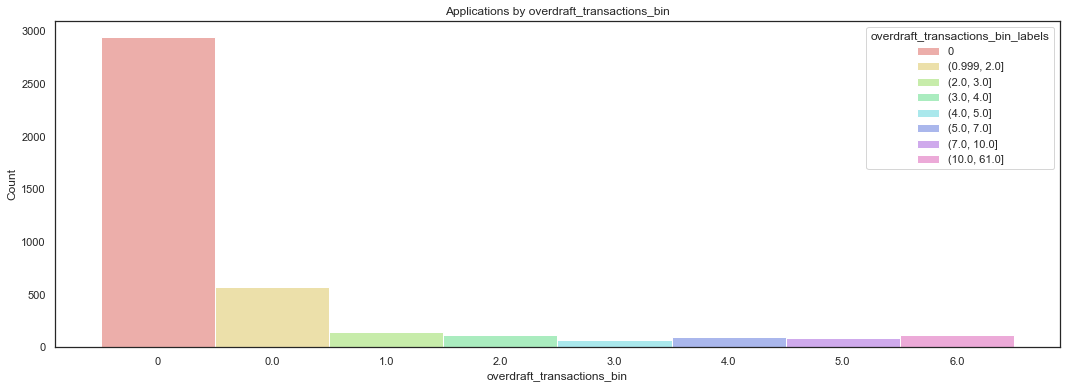

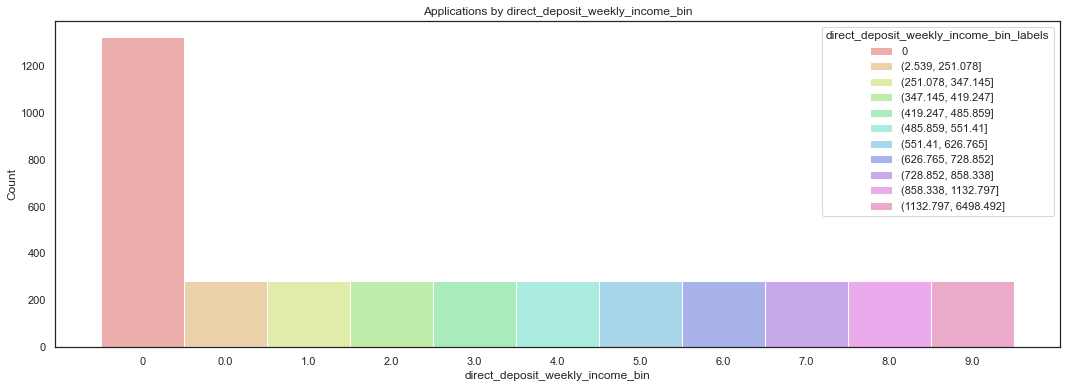

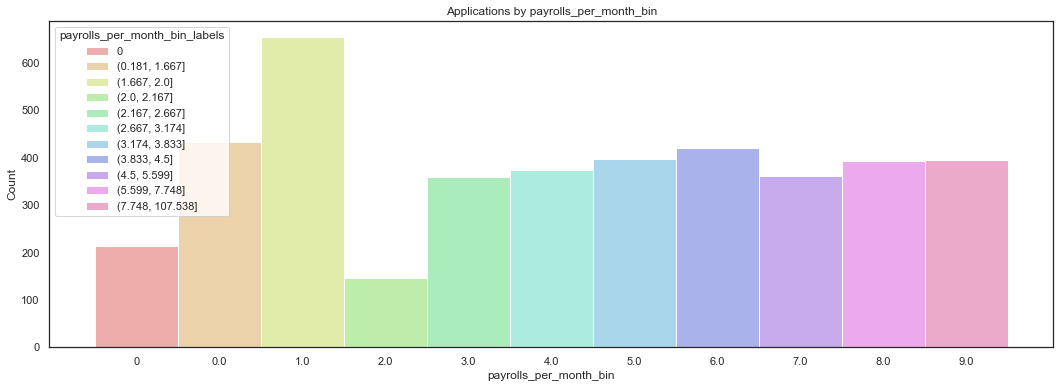

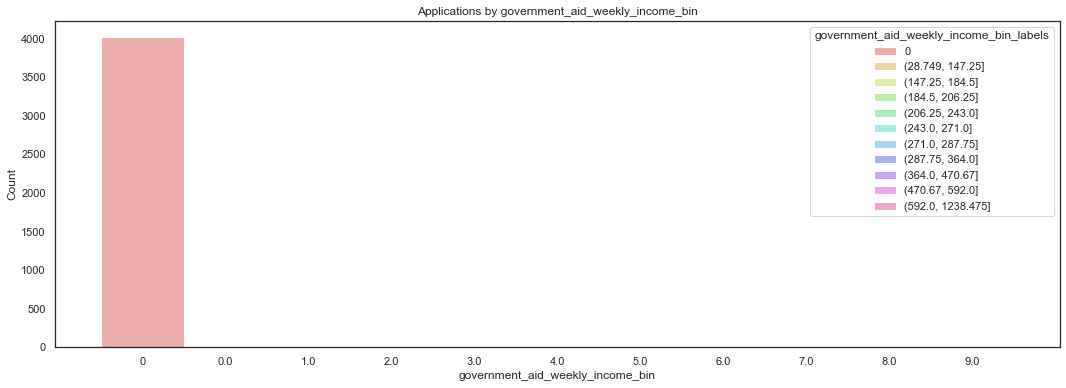

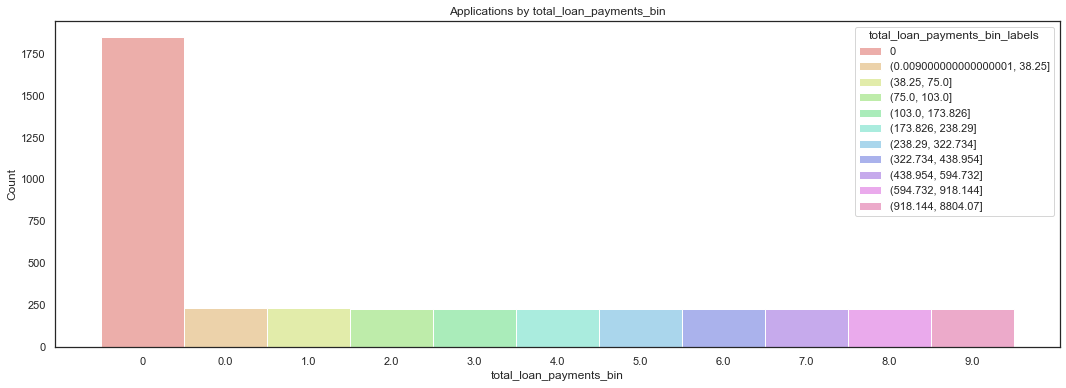

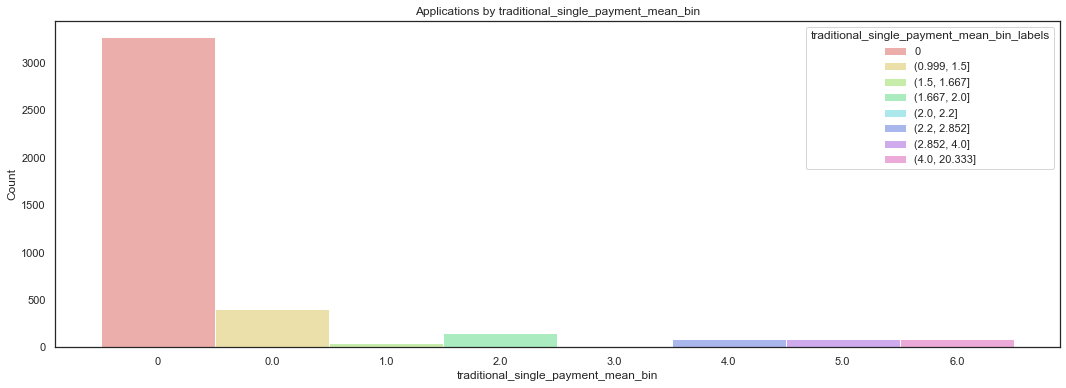

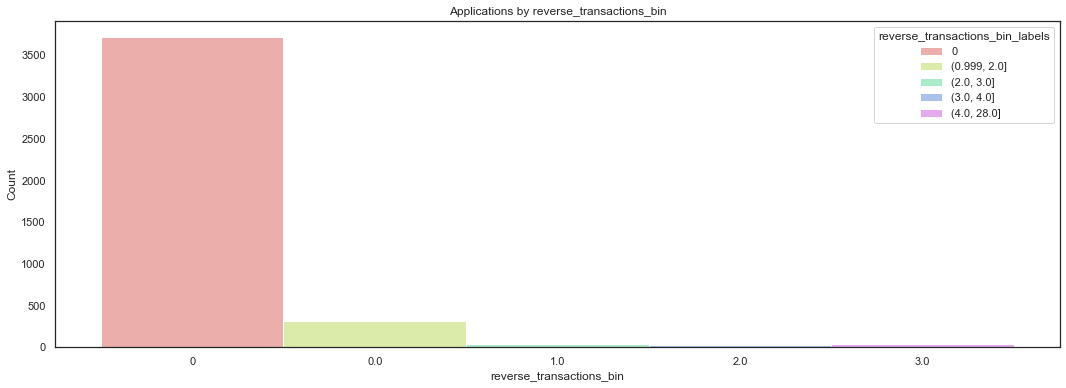

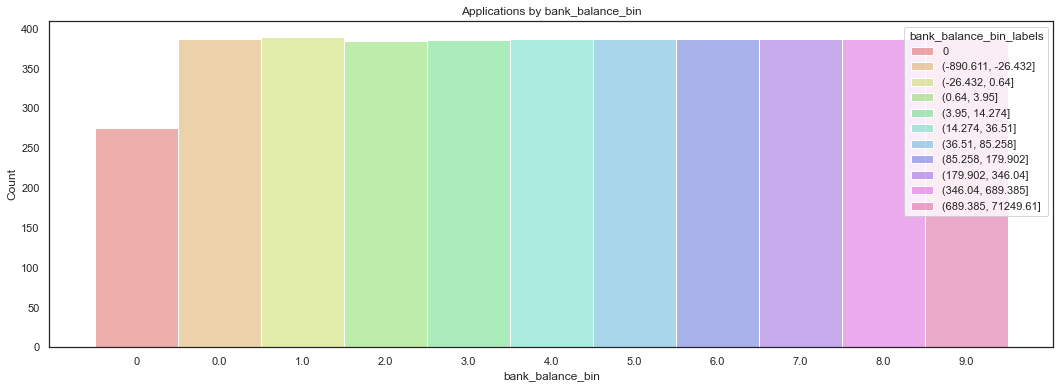

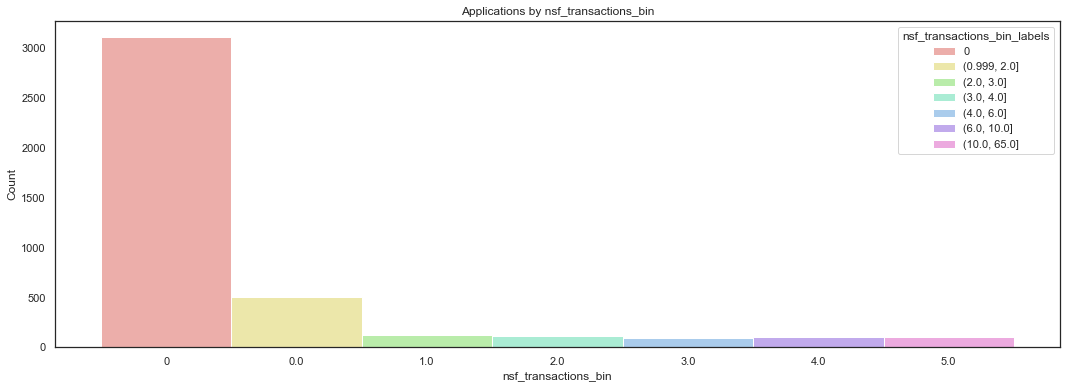

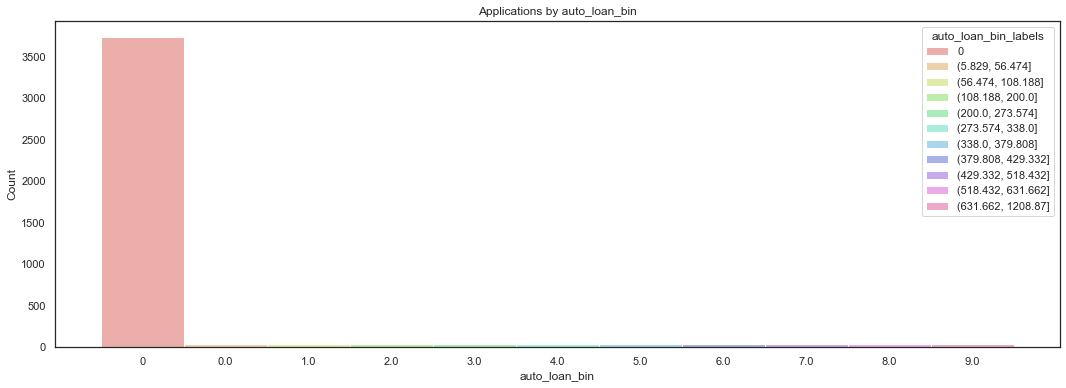

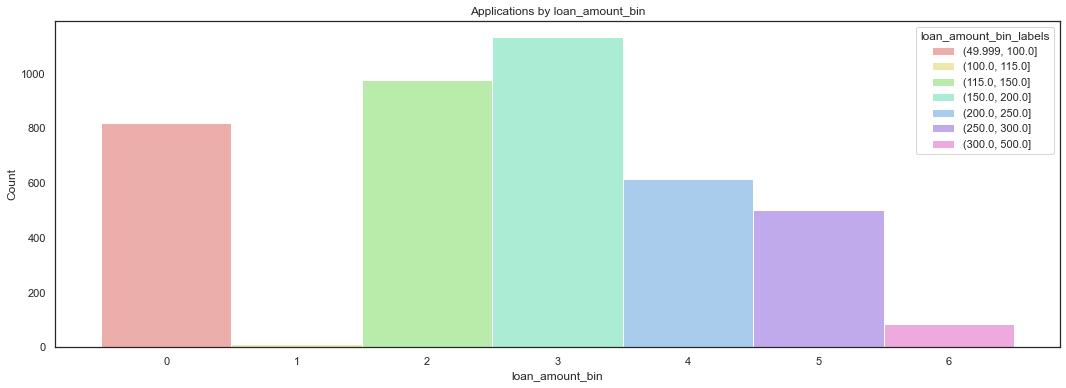

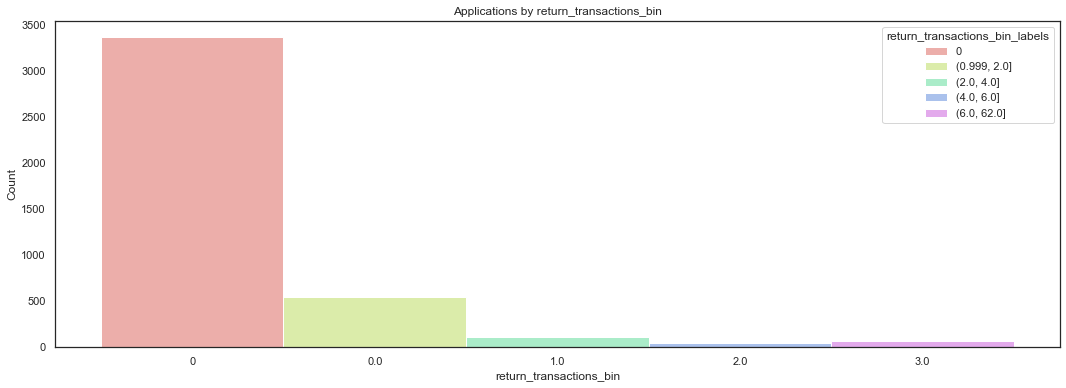

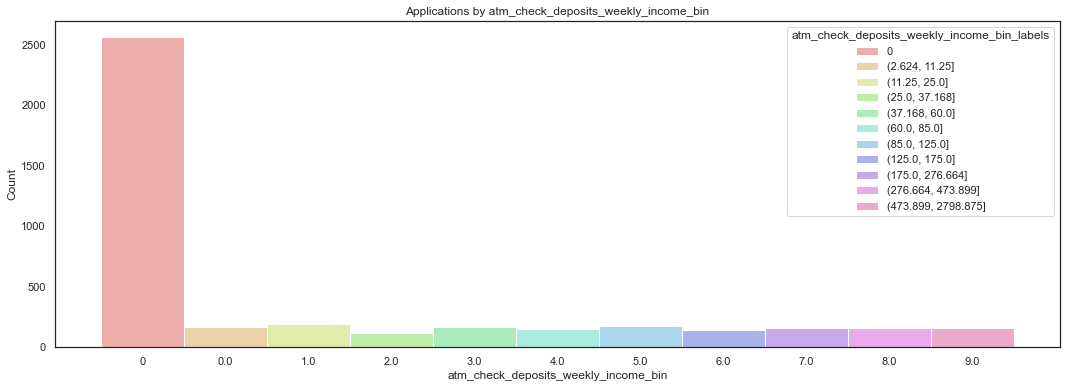

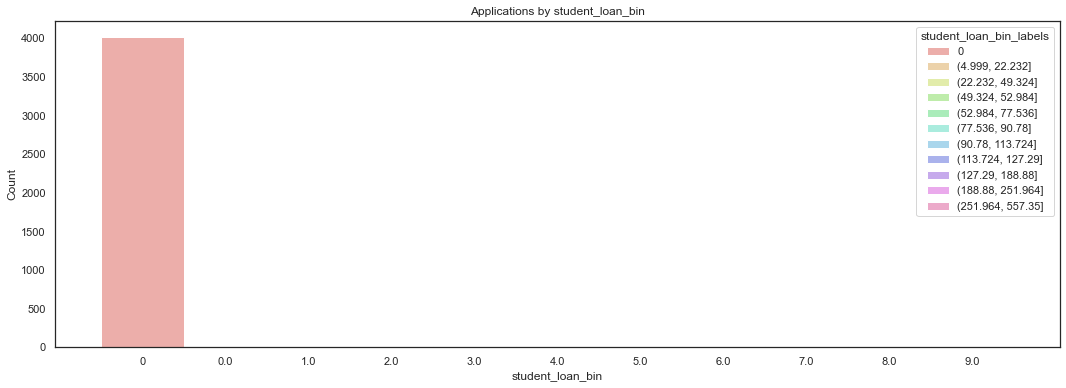

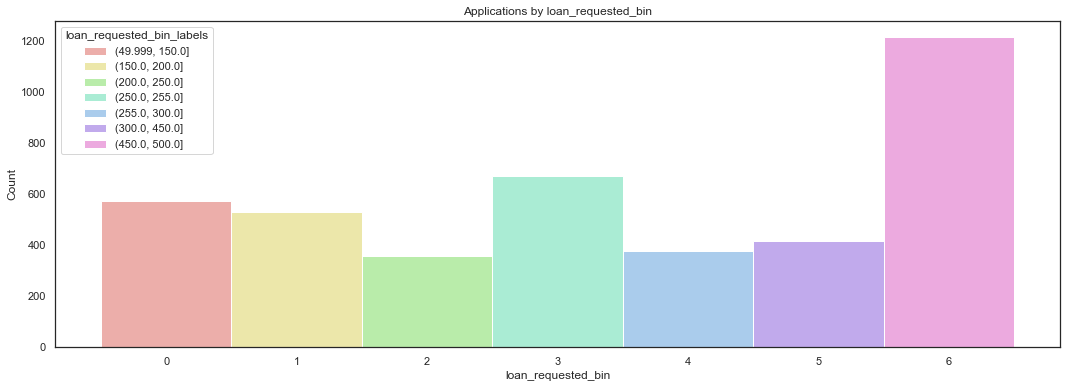

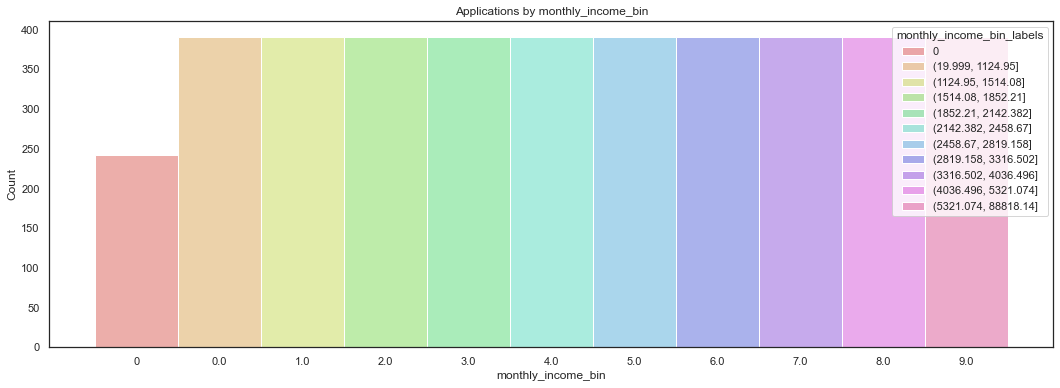

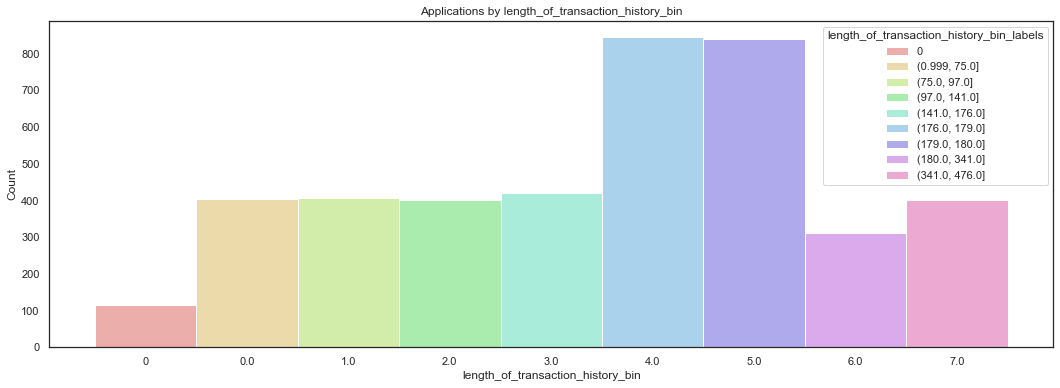

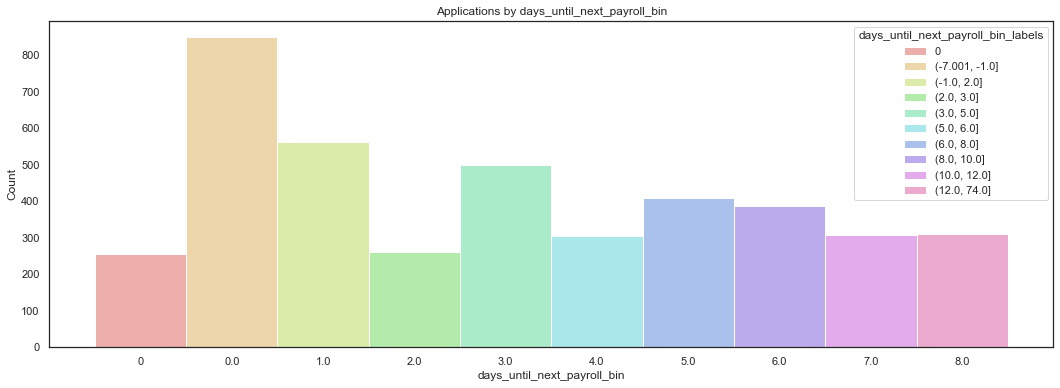

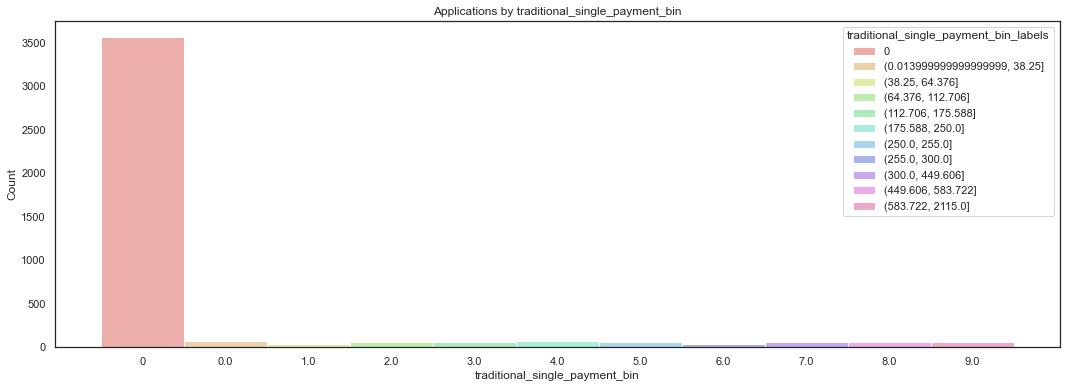

In [14]:
# plot remaining columns 
sns.set(rc={'figure.figsize':(16,8)})
for i in lst_bins:
    plt.figure(figsize=(18,6))
    sns.set_style(style='white') 
    sns.histplot(data=applications_approved.sort_values(by=i), x=i, hue = i + '_labels', 
                 binwidth= 1, palette = 'hls', legend = True).set(title = 'Applications by ' + i) # , 
    plt.show()

- We can see that there are some features that have a very high percentage of their values concentrated in zero. These will likely not be very useful in a prediction (for instance, the mortgages or student loans features). 

- *return, nsf and reverse transactions* seem to have quite similar shapes. As they indicate to quite similar behaviour, it's likely not all of them should be included in the model. 

## Bivariate analysis

I analyze all the features vs the target. The graphs show the distribution, for each of the categories, of the target. 

In the case of the binned features, I leave the bin number as reference as it is easier to sort and see how the features relate to each other. 

In [18]:
# Functions
def pct_bar_labels(ax1):
    plt.ylabel('Relative Frequency (%)')
    plt.xticks(rotation = 0)
    plt.yticks([])   
    # Set individual bar lebels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center', xytext = (0, 7), 
        textcoords = 'offset points', fontsize = 10, color = 'black')

def composition(cat, cat_target): 
    pct_cat_grouped_by_cat_target = round(pd.crosstab(index = cat, columns = cat_target, normalize = 'index')*100, 2)
    #pct_cat_grouped_by_cat_target.sort_values(by=1, inplace=True)
    
    # Plot relative freq of target by a categorical variable
    sns.set(rc={'figure.figsize':(18,6)})
    sns.set_style(style='white') 
    
    ax1 = pct_cat_grouped_by_cat_target.plot.bar(color = ['#E74C3C', '#76D7C4'])
    plt.title('Percentage target by %s' %cat.name)
    pct_bar_labels(ax1)
    plt.show()

In [16]:
# list of categorical features plus the binned continuous features
var_list = feat_list + lst_bins 

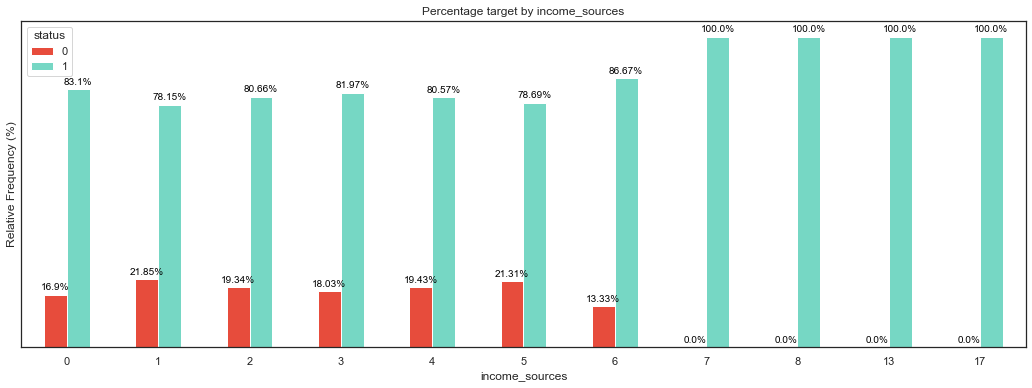

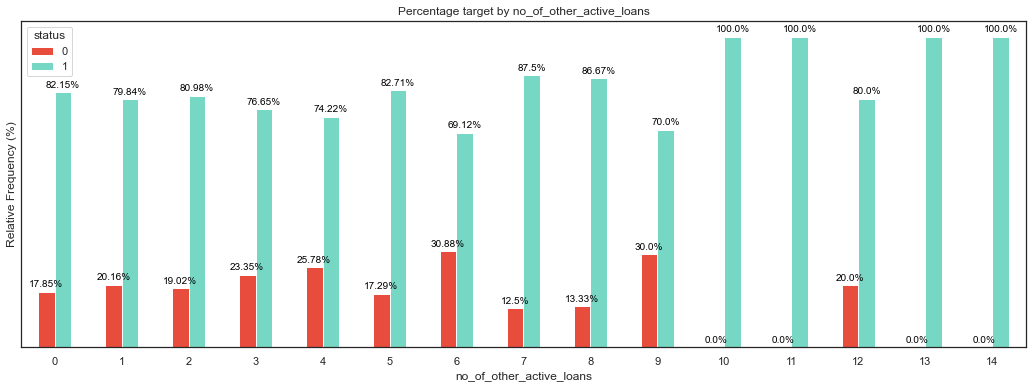

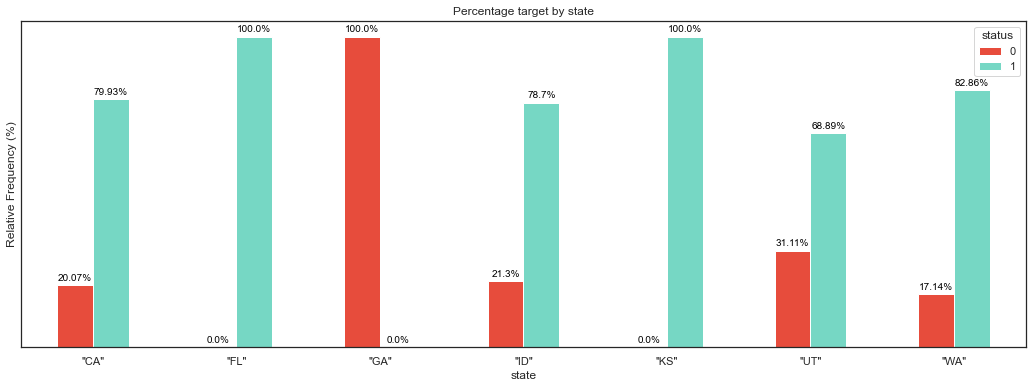

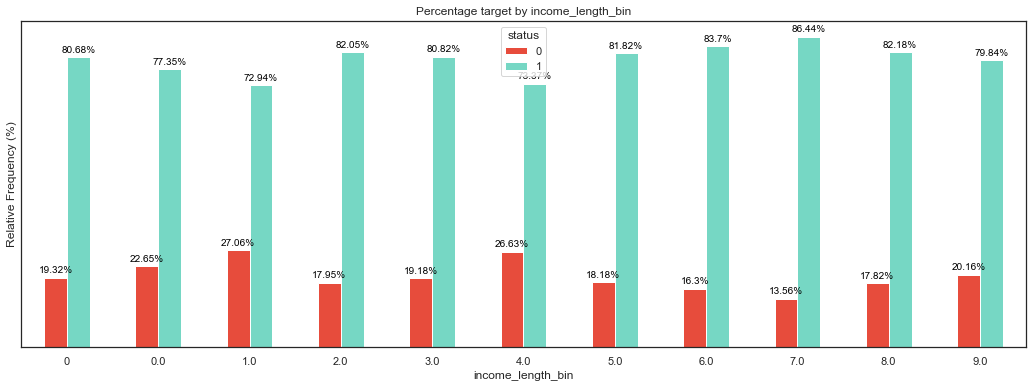

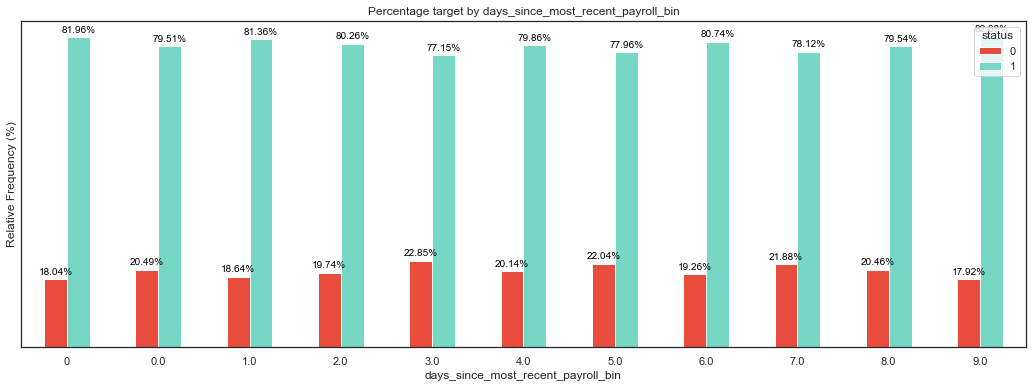

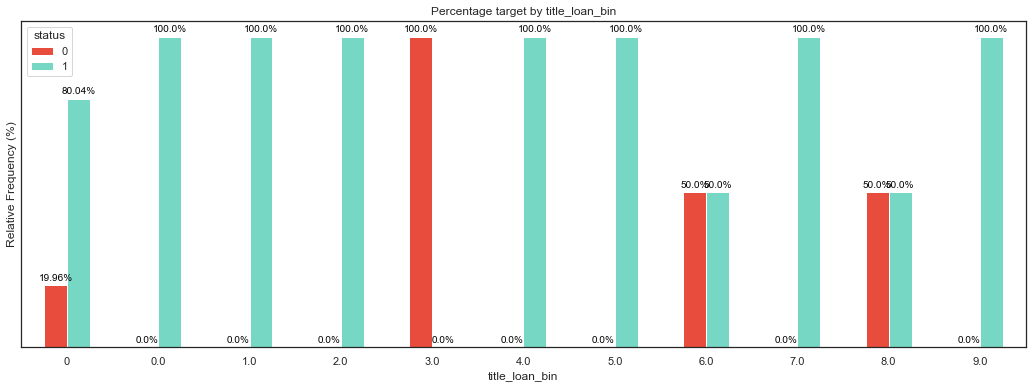

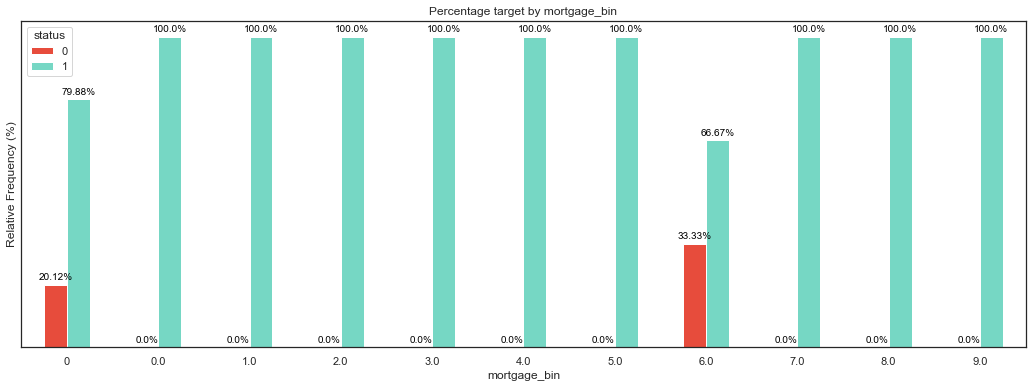

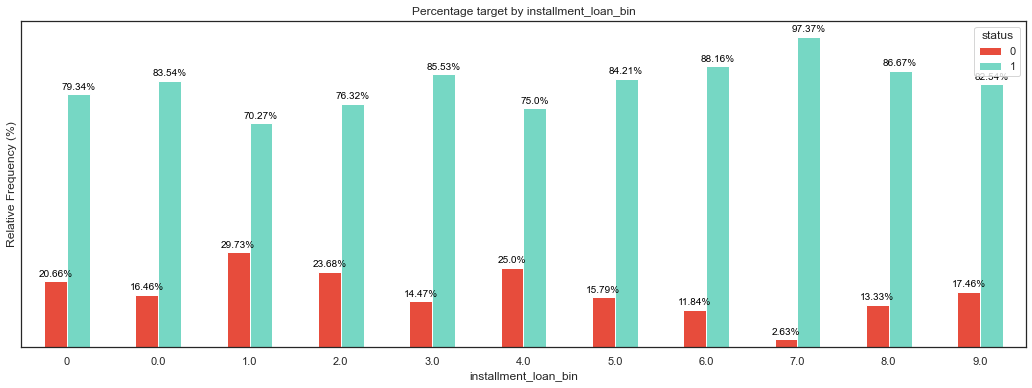

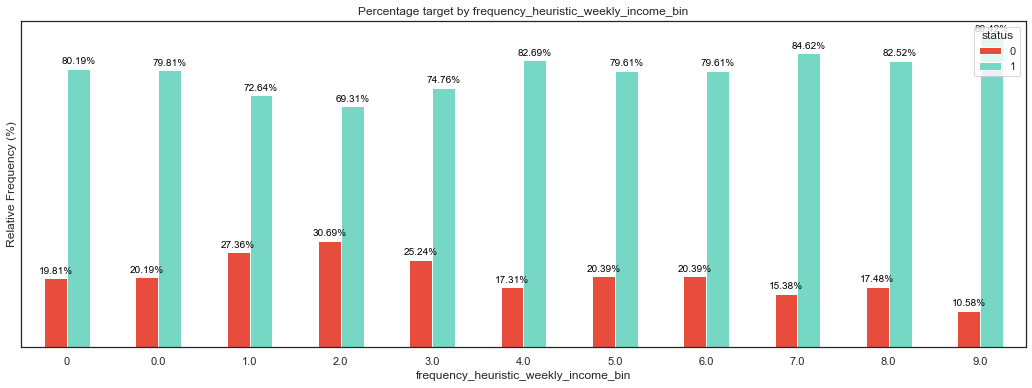

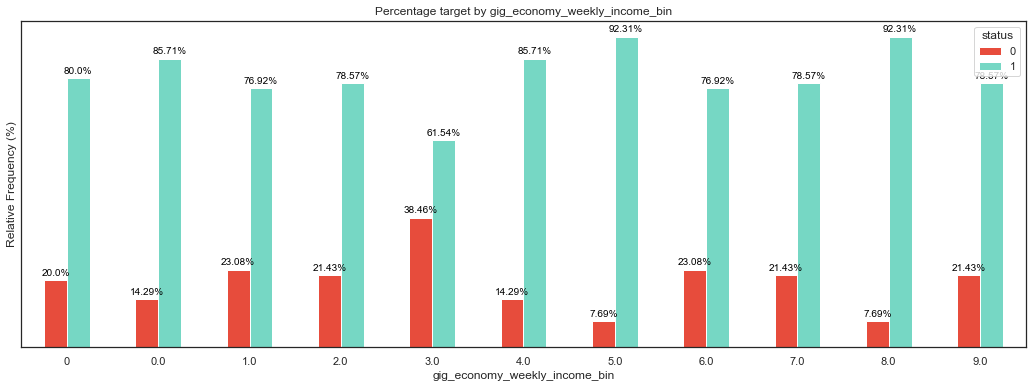

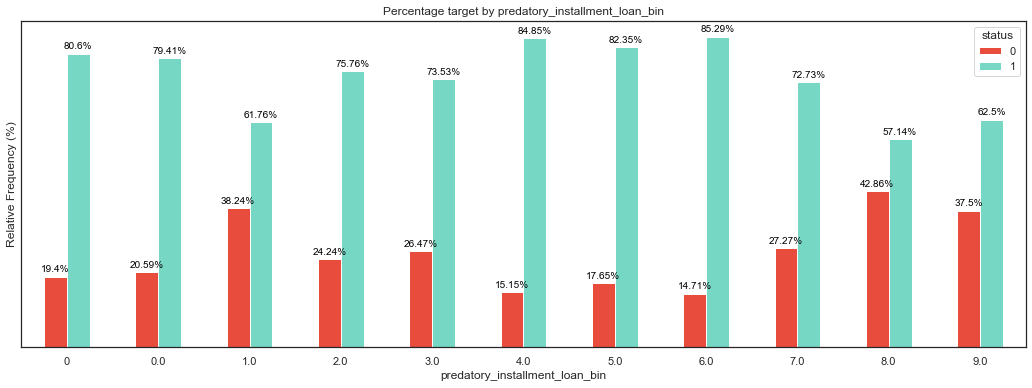

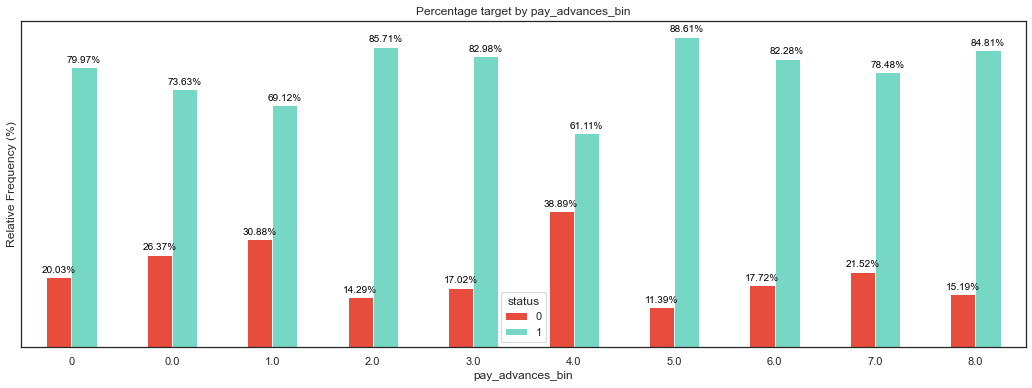

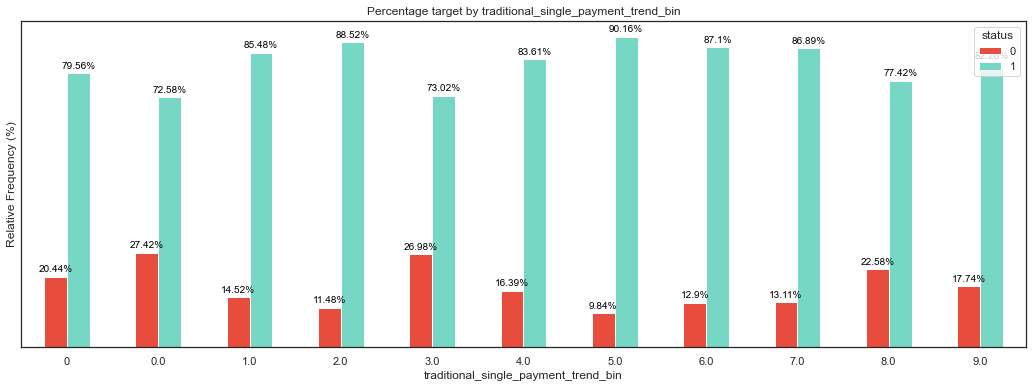

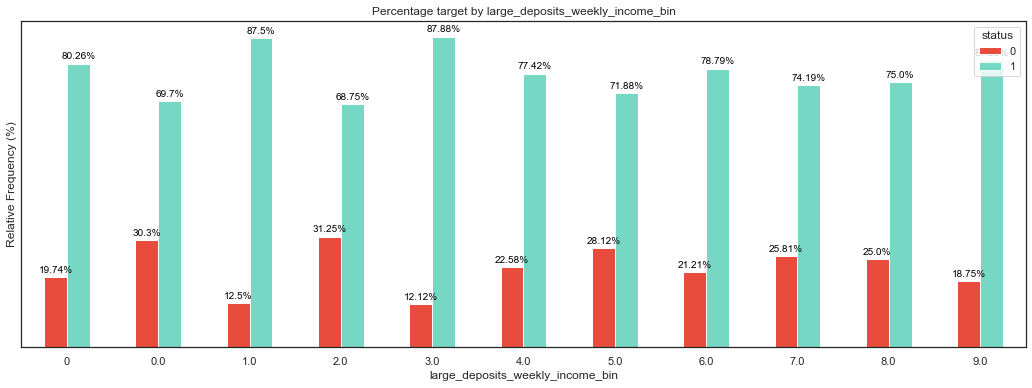

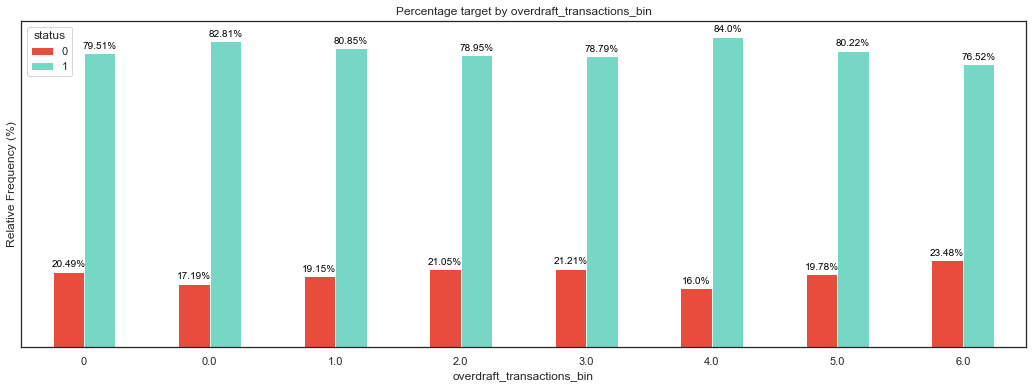

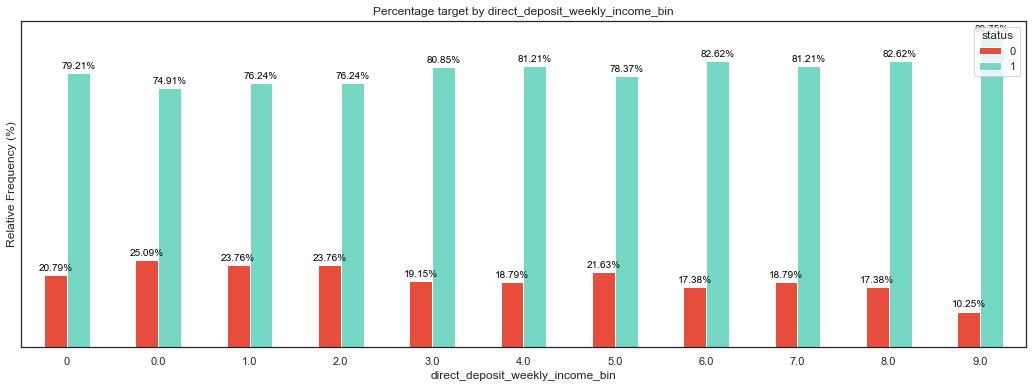

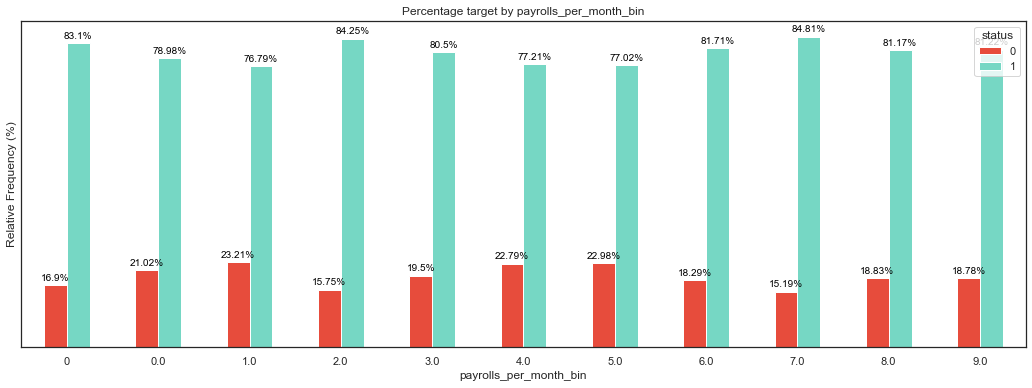

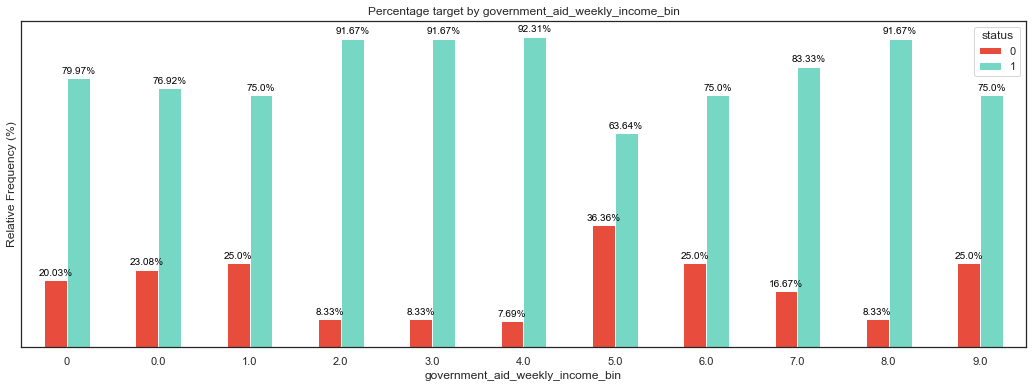

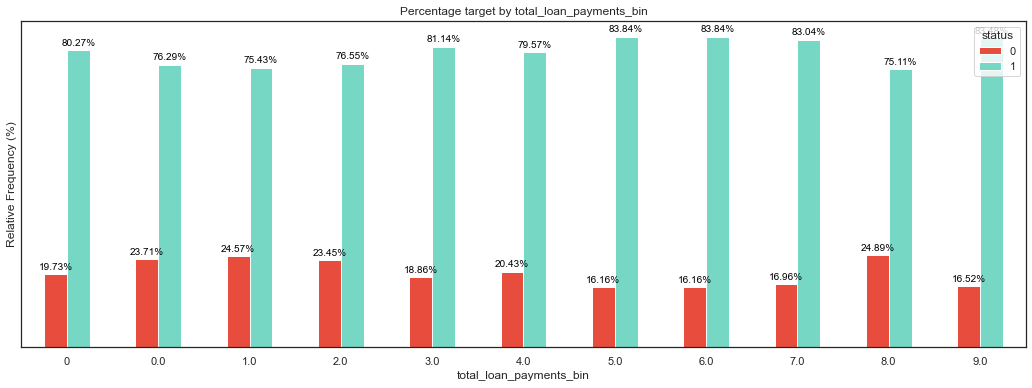

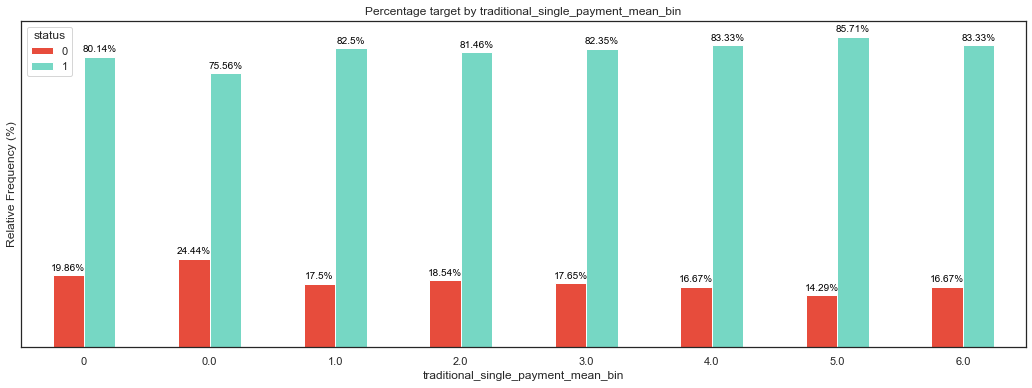

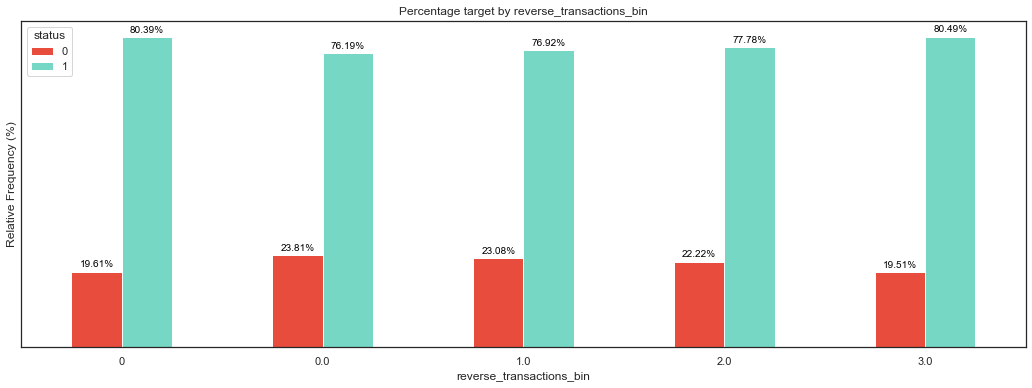

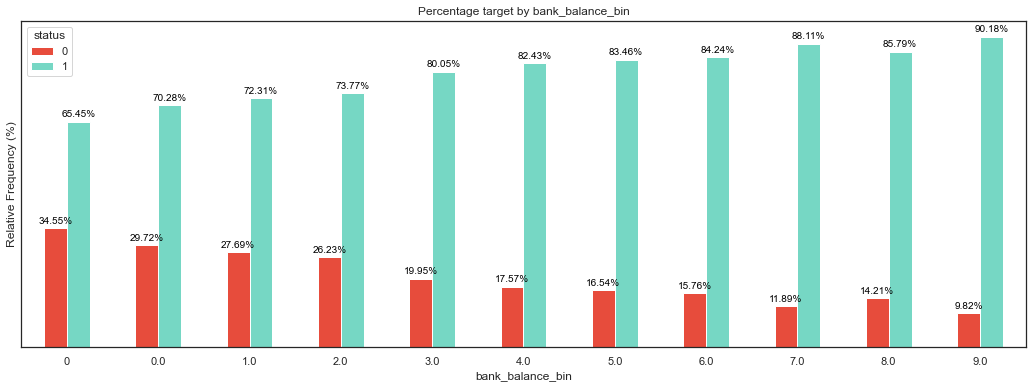

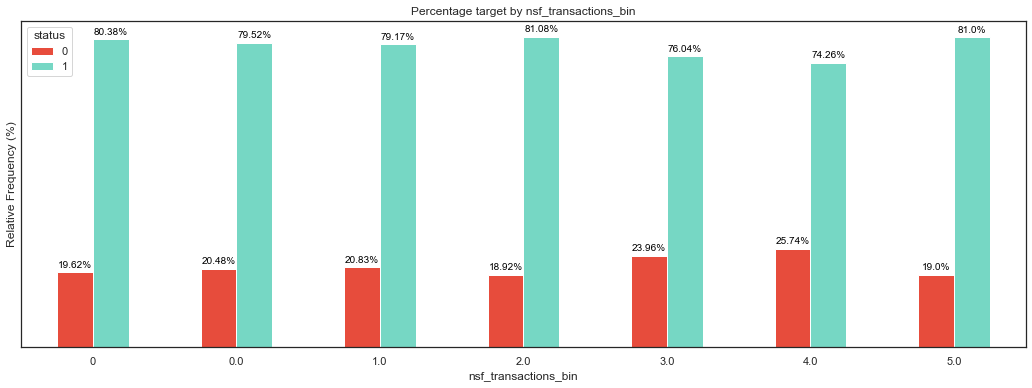

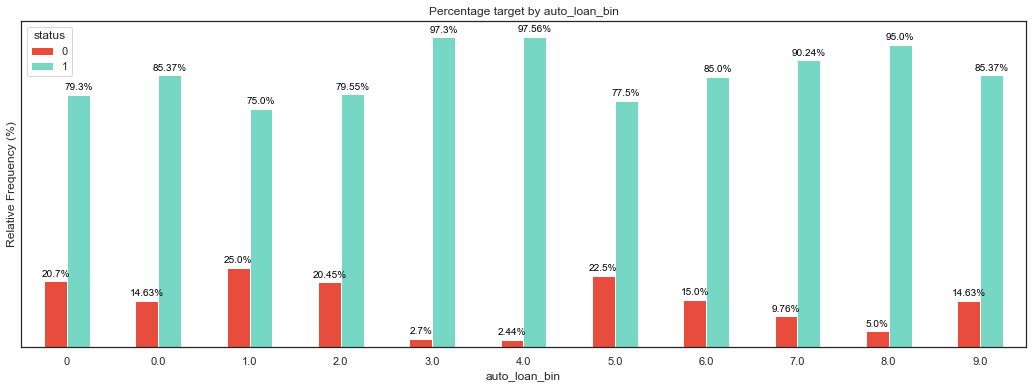

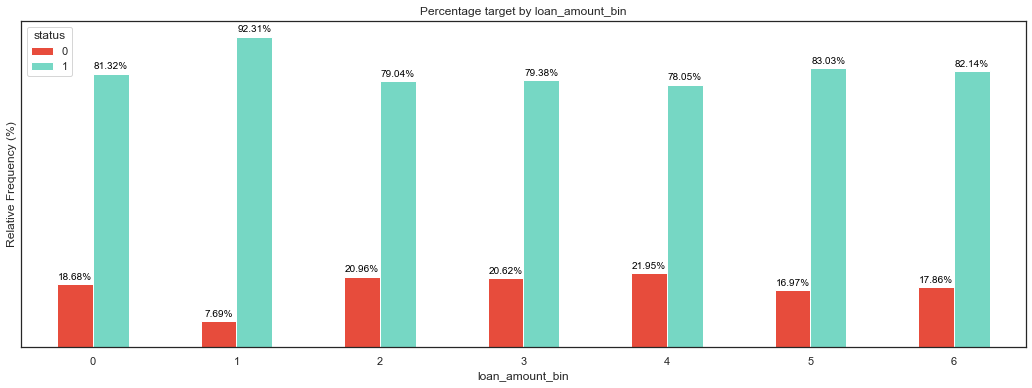

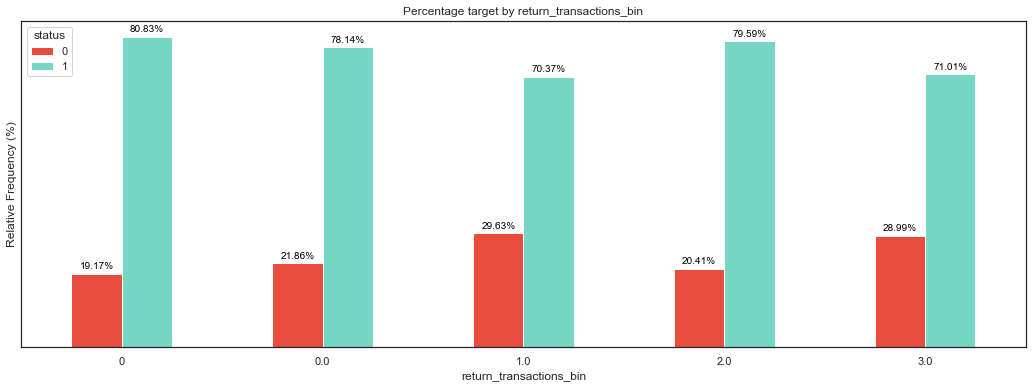

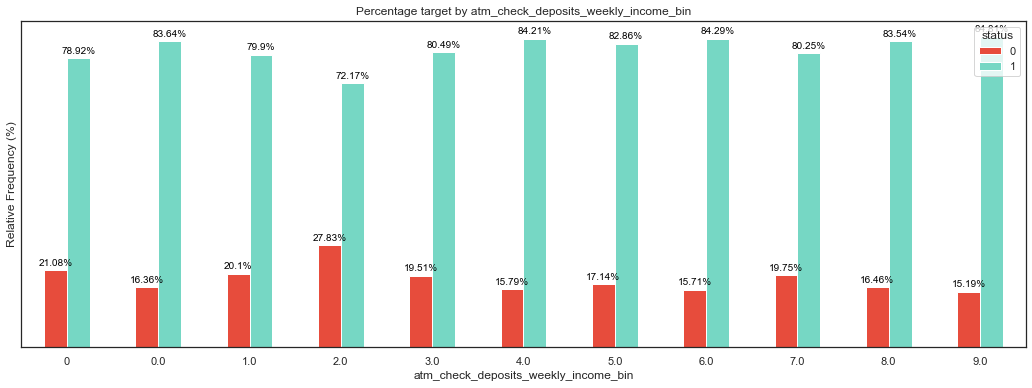

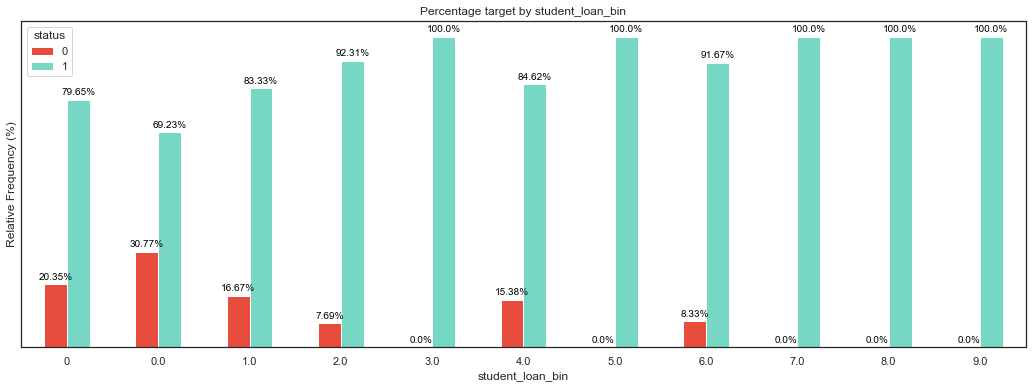

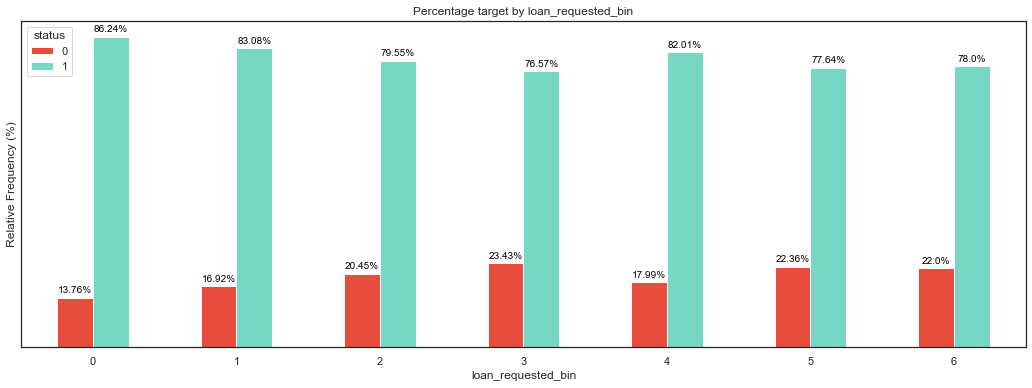

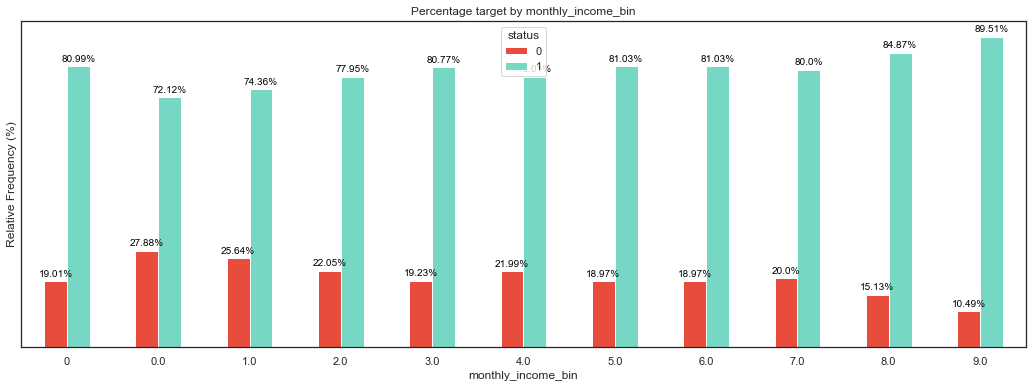

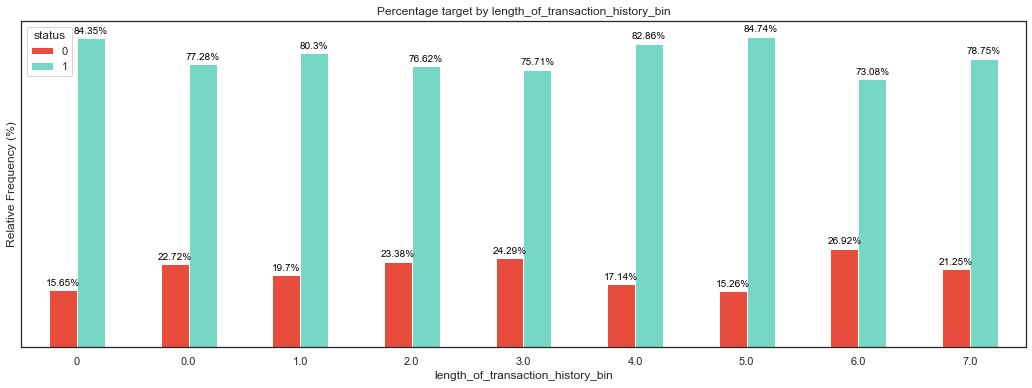

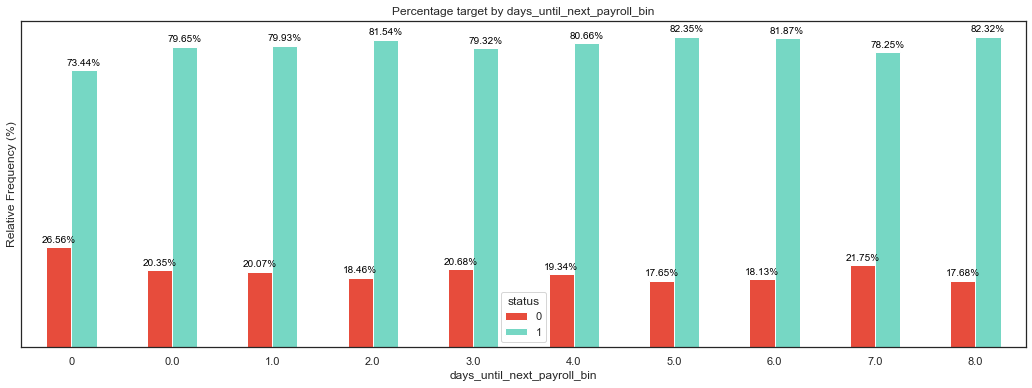

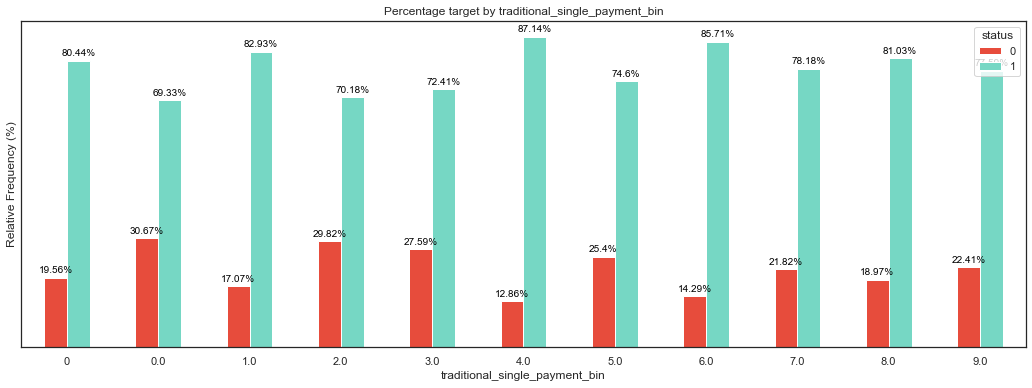

In [19]:
for i in var_list:
    composition(applications_approved[i], applications_approved.status)

There don't seem to be many features were there is a clear linear relation between the feature and the target, with the exception of *bank_balance*, where the relation seems quite clear. 
*loan requested* seems to have somewhat of a linear relationship as well, where there seems to be a small increase in the % of poor performer toward the higher bins. 

- *installment loan* and *traditional loan* seem to have quite similar behaviour. 
- income sources seems to have higher percentage of loans in good standing, but upon further inspection, those categories have very little applicants
- *mortgage*, *student_loan* and *title loan* seem to have very different behaviour as well in some of the segments, but as it was previously seen in the univariate analysis, both features have very high concentration in the zero value, so we can think they will not be very useful in modelling.

## Correlation matrix

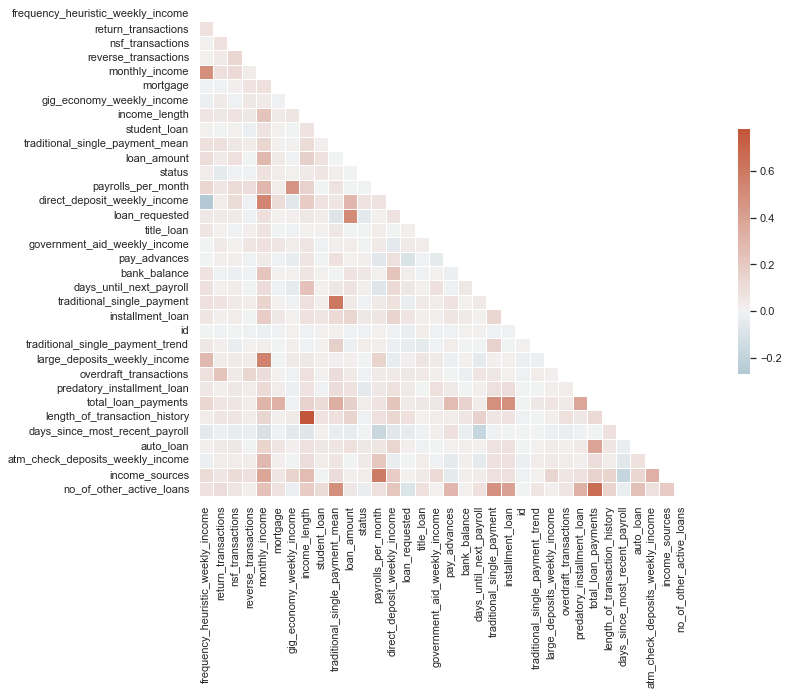

In [282]:
data_corr = applications_approved.loc[:,cols + ['income_sources','no_of_other_active_loans']]

# Get correlation matrix
corr = round(data_corr.corr(),2)

# plot 
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

We can see there are some features that are highly correlated and seem to have similar meanings, which would mean some of them will be candidates to be removed when modelling.  

### Correlation of each feature with target 

#### Numerical features

I will use point biserial correlation to see correlation of numerical features with the target. This tests the null hypothesis that the correlation is zero in the population. If p is lower or equal than 0.05, we can confidently say that the correlation is statistically significant. 

In [205]:
# Calculate point biserial correlation for each numeric feature with the target 
point_biserial = []
p_value = []
for i in cols: 
    pont_biser_i = stats.pointbiserialr(applications_approved[i], applications_approved['status'])
    point_biserial.append(round(pont_biser_i[0],2)) # extracting correlation coefficient
    p_value.append(round(pont_biser_i[1],3)) # extracting p-value

In [214]:
df_corr_num_target = pd.DataFrame({'feature': cols, 'corr' : point_biserial, 'p_value' : p_value})

# keeping only features where the correlation is significant
df_corr_num_target = df_corr_num_target[df_corr_num_target.p_value <= 0.05]
df_corr_num_target.sort_values(by='corr',ascending=False)

,feature,corr,p_value
11,status,1.00,0.000
4,monthly_income,0.08,0.000
13,direct_deposit_weekly_income,0.07,0.000
8,student_loan,0.06,0.000
18,bank_balance,0.05,0.001
21,installment_loan,0.05,0.003
30,auto_loan,0.05,0.001
7,income_length,0.04,0.022
31,atm_check_deposits_weekly_income,0.04,0.015
5,mortgage,0.03,0.027


#### Categorical features

Chi-square Test: The Chi-square test of independence tests if there is a significant relationship between two categorical variables.

- *H0*: There is no relationship between variable one and variable two.<br>
- *H1* : There is a relationship between variable 1 and variable 2.<br>

If the p-value is lower than 0.05, we can reject H0 and claim that the findings support the alternate hypothesis. For the chi2 test, we need also to check that the expected cell frequencies are greater than or equal to 5. 

In [274]:
def chi_square(varname, cat, cat_target):
    cat_grouped_by_cat_target = pd.crosstab(index = cat, columns = cat_target)
    test_result = stats.chi2_contingency(cat_grouped_by_cat_target)
    arr = test_result[3]
    greater_than = all(x >= 5 for x in [item for sublist in arr for item in sublist]) 
    
    rslt = pd.DataFrame({'feature' : [varname], 'coef' : [test_result[0]], 
                         'p-value': [round(test_result[1],3)], 'is_greater_than_5' : greater_than})
    
    return rslt

In [275]:
df_corr_cat_target = pd.DataFrame()

for i in feat_list: 
    df_i = chi_square(i, applications_approved[i], applications_approved['status'])
    df_corr_cat_target = df_corr_cat_target.append(df_i) 

In [276]:
df_corr_cat_target

,feature,coef,p-value,is_greater_than_5
0,income_sources,10.654980,0.385,False
0,no_of_other_active_loans,23.588227,0.051,False
0,state,60.492682,0.000,False


*state* and *no_of_other_active_loans* have a p-value lower or equal than 0.05. But, as their expected frequencies are not all 5 or equal, we cannot safely reject H0. 